# Building a Multivariate Regression Model: Weather Vs. Bike Trips 

The goal of this proejct is to analyse the lengths and frequency of bike share trips based on the weather in San Francisco on a given day. I am going to create a regression model to see if the Bike Rental Company should expect a trend in the number of rentals based on weather patterns, and since they charge by the minute, how trip length is additionally affected.

[Weather data](https://github.com/zonination/weather-us/blob/master/sanfrancisco.csv) used was compiled by GitHub user zonination. Bike data is taken from a Big Query Public Database. 

## Part One: Loading & Cleaning Data

After examining the head of both tables, I first determined what dates are present in both datasets. These are the dates that I used in my models. Then, I queried the Bike Share database to create a table with only the relevant columns. I chose to look at the number of rentals and average trip length on a given day, and rolling averages for both measures. I trimmed the weather table to only include relevant dates, and created dummy variables in place of the categorical variables that were present in the weather table. I also modified the column that contained precipitation data in order to change it to a numeric data type. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
weather = pd.read_csv('/Users/Austen/Desktop/python/sanfrancisco_weather.csv')

In [2]:
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='/Users/Austen/Desktop/python/My Project 47099-03fe77cc4fd6.json'
from google.cloud import bigquery
from google.cloud import bigquery_storage
client = bigquery.Client(project = 'lyrical-compass-298919')
dataset_ref = client.dataset("san_francisco", project="bigquery-public-data")
dataset = client.get_dataset(dataset_ref)
table_ref = dataset_ref.table("bikeshare_trips")
table = client.get_table(table_ref)
client.list_rows(table, max_results=5).to_dataframe()

/Users/Austen/opt/anaconda3/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1765: UserWarning: Cannot use bqstorage_client if max_results is set, reverting to fetching data with the REST endpoint.
  if not self._validate_bqstorage(bqstorage_client, create_bqstorage_client):


,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,944732,2618,2015-09-24 17:22:00+00:00,Mezes,83,2015-09-24 18:06:00+00:00,Mezes,83,653,94063,Customer
1,984595,5957,2015-10-25 18:12:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,52,nil,Customer
2,984596,5913,2015-10-25 18:13:00+00:00,Mezes,83,2015-10-25 19:51:00+00:00,Mezes,83,121,nil,Customer
3,1129385,6079,2016-03-18 10:33:00+00:00,Mezes,83,2016-03-18 12:14:00+00:00,Mezes,83,208,94070,Customer
4,1030383,5780,2015-12-06 10:52:00+00:00,Mezes,83,2015-12-06 12:28:00+00:00,Mezes,83,44,94064,Customer


In [3]:
weather.head()

,Unnamed: 0,Date,Max.TemperatureF,Mean.TemperatureF,Min.TemperatureF,Max.Dew.PointF,MeanDew.PointF,Min.DewpointF,Max.Humidity,Mean.Humidity,...,Min.VisibilityMiles,Max.Wind.SpeedMPH,Mean.Wind.SpeedMPH,Max.Gust.SpeedMPH,PrecipitationIn,CloudCover,Events,WindDirDegrees.br...,city,season
0,1,1948-01-01,55,50.0,46.0,53.0,48.0,42.0,96.0,87.0,...,2.0,16.0,7.0,NaN,0.00,0.0,Fog-Rain,124<br />,San Francisco (CA),Winter
1,2,1948-01-02,57,55.0,53.0,56.0,53.0,51.0,93.0,91.0,...,3.0,22.0,11.0,NaN,0.00,0.0,Rain,202<br />,San Francisco (CA),Winter
2,3,1948-01-03,57,54.0,50.0,54.0,51.0,50.0,100.0,94.0,...,0.0,8.0,2.0,NaN,0.00,0.0,Fog,79<br />,San Francisco (CA),Winter
3,4,1948-01-04,59,57.0,55.0,55.0,54.0,54.0,97.0,91.0,...,3.0,18.0,7.0,NaN,0.00,0.0,Fog-Rain,191<br />,San Francisco (CA),Winter
4,5,1948-01-05,59,55.0,51.0,55.0,52.0,50.0,100.0,91.0,...,0.0,12.0,4.0,NaN,0.00,0.0,Fog,289<br />,San Francisco (CA),Winter


In [4]:
weather.describe()

,Unnamed: 0,Max.TemperatureF,Mean.TemperatureF,Min.TemperatureF,Max.Dew.PointF,MeanDew.PointF,Min.DewpointF,Max.Humidity,Mean.Humidity,Min.Humidity,Max.Sea.Level.PressureIn,Mean.Sea.Level.PressureIn,Min.Sea.Level.PressureIn,Max.VisibilityMiles,Mean.VisibilityMiles,Min.VisibilityMiles,Max.Wind.SpeedMPH,Mean.Wind.SpeedMPH,Max.Gust.SpeedMPH,CloudCover
count,24743.000000,24743.000000,24741.000000,24742.000000,24742.000000,24742.000000,24742.000000,24742.000000,24742.000000,24742.000000,24742.000000,24742.000000,24742.000000,24741.000000,24741.000000,24741.000000,24742.000000,24742.000000,8504.000000,22908.000000
mean,12405.428687,64.362082,57.152500,49.828268,51.242624,47.620443,43.808787,89.799531,74.406071,54.907202,30.090261,30.033948,29.977228,14.197365,10.681662,7.271008,20.432867,9.901059,29.228598,2.569801
std,7162.463166,8.647735,6.567785,5.846138,5.589795,6.219658,7.653558,7.628870,10.274828,14.251179,0.137716,0.136534,0.141723,4.286248,2.862666,3.563762,6.730061,4.359932,8.279627,2.677867
min,1.000000,0.000000,30.000000,25.000000,15.000000,10.000000,0.000000,36.000000,25.000000,7.000000,29.270000,29.030000,28.820000,1.000000,0.000000,0.000000,4.000000,0.000000,6.000000,0.000000
25%,6202.500000,58.000000,52.000000,46.000000,48.000000,44.000000,39.000000,86.000000,69.000000,47.000000,29.990000,29.940000,29.890000,10.000000,9.000000,5.000000,16.000000,7.000000,24.000000,0.000000
50%,12405.000000,64.000000,58.000000,51.000000,52.000000,49.000000,45.000000,90.000000,76.000000,56.000000,30.070000,30.020000,29.970000,15.000000,10.000000,8.000000,21.000000,10.000000,29.000000,2.000000
75%,18607.500000,70.000000,62.000000,54.000000,55.000000,52.000000,50.000000,96.000000,81.000000,64.000000,30.180000,30.120000,30.060000,20.000000,13.000000,10.000000,24.000000,13.000000,33.000000,5.000000
max,24810.000000,105.000000,85.000000,69.000000,67.000000,64.000000,62.000000,100.000000,100.000000,100.000000,30.780000,30.570000,30.510000,20.000000,20.000000,20.000000,132.000000,39.000000,204.000000,8.000000


In [5]:
weather.columns

Index(['Unnamed: 0', 'Date', 'Max.TemperatureF', 'Mean.TemperatureF',
       'Min.TemperatureF', 'Max.Dew.PointF', 'MeanDew.PointF', 'Min.DewpointF',
       'Max.Humidity', 'Mean.Humidity', 'Min.Humidity',
       'Max.Sea.Level.PressureIn', 'Mean.Sea.Level.PressureIn',
       'Min.Sea.Level.PressureIn', 'Max.VisibilityMiles',
       'Mean.VisibilityMiles', 'Min.VisibilityMiles', 'Max.Wind.SpeedMPH',
       'Mean.Wind.SpeedMPH', 'Max.Gust.SpeedMPH', 'PrecipitationIn',
       'CloudCover', 'Events', 'WindDirDegrees.br...', 'city', 'season'],
      dtype='object')

In [6]:
print(max(weather['Date']))

2015-12-31


In [7]:
query = """SELECT 
min(start_date) as first_date,
max(start_date) as last_date
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
"""
query1 = client.query(query).to_dataframe()
query1.head()

,first_date,last_date
0,2013-08-29 09:08:00+00:00,2016-08-31 23:32:00+00:00


In [8]:
query = '''SELECT
distinct subscriber_type
FROM `bigquery-public-data.san_francisco.bikeshare_trips`'''

query1 = client.query(query).to_dataframe()
query1.head()

,subscriber_type
0,Customer
1,Subscriber


### 1.1

For both datasets, I can use the dates between 8-29-2013 and 12-31-2015. 

In [9]:
query = '''
WITH day_data AS (SELECT
CAST(start_date as DATE) as trip_date,
count(trip_id) as num_trips,
round(avg(duration_sec)/60,2) as avg_trip_length_mins
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
GROUP BY trip_date
order by trip_date)
SELECT
trip_date,
num_trips,
avg_trip_length_mins,
AVG(num_trips) OVER(
ORDER BY trip_date
ROWS BETWEEN 7 PRECEDING AND CURRENT ROW
) AS rolling_avg_trips,
AVG(avg_trip_length_mins) OVER(
ORDER BY trip_date
ROWS BETWEEN 7 PRECEDING AND CURRENT ROW
) AS rolling_avg_length
FROM day_data
WHERE trip_date BETWEEN '2013-08-29' AND '2015-12-31'
ORDER BY trip_date

'''


bike_trips = client.query(query).to_dataframe()
bike_trips.head(10)

,trip_date,num_trips,avg_trip_length_mins,rolling_avg_trips,rolling_avg_length
0,2013-08-29,748,26.02,748.000000,26.020000
1,2013-08-30,714,45.05,731.000000,35.535000
2,2013-08-31,640,61.00,700.666667,44.023333
3,2013-09-01,706,56.77,702.000000,47.210000
4,2013-09-02,661,38.92,693.800000,45.552000
5,2013-09-03,597,29.07,677.666667,42.805000
6,2013-09-04,606,29.53,667.428571,40.908571
7,2013-09-05,677,23.74,668.625000,38.762500
8,2013-09-06,814,27.33,676.875000,38.926250
9,2013-09-07,796,40.70,687.125000,38.382500


In [10]:
bike_trips.rename(columns={"trip_date": "Date"},inplace=True)
bike_trips.head()

,Date,num_trips,avg_trip_length_mins,rolling_avg_trips,rolling_avg_length
0,2013-08-29,748,26.02,748.000000,26.020000
1,2013-08-30,714,45.05,731.000000,35.535000
2,2013-08-31,640,61.00,700.666667,44.023333
3,2013-09-01,706,56.77,702.000000,47.210000
4,2013-09-02,661,38.92,693.800000,45.552000


In [11]:
weather = weather[weather['Date'] >= '2013-08-29']
weather = weather.reset_index(drop = True)

In [12]:
pd.to_datetime(weather['Date'])

0     2013-08-29
1     2013-08-30
2     2013-08-31
3     2013-09-01
4     2013-09-02
         ...    
850   2015-12-27
851   2015-12-28
852   2015-12-29
853   2015-12-30
854   2015-12-31
Name: Date, Length: 855, dtype: datetime64[ns]

In [13]:
weather['Events'].value_counts(dropna=False)

NaN                  697
Rain                 115
Fog                   33
Rain-Thunderstorm      5
Fog-Rain               3
Thunderstorm           2
Name: Events, dtype: int64

### 1.2 Coding Categorical Variables
Since the majority of the days were clear, I am going to create a binary dummy variable to represent this data: 0 if the weather was clear, 1 if there was an event. 

I am also going to create three dummy variables for the seasons. Since Autumn has the most entries, I chose it as the default. 

In [14]:
weather['Events Binary'] = np.where(weather['Events'].notnull() , 1, 0)
weather['season'].value_counts()

Autumn    267
Summer    213
Winter    189
Spring    186
Name: season, dtype: int64

In [15]:
weather['Summer'] = np.where(weather['season'] == 'Summer',1,0)
weather['Winter'] = np.where(weather['season'] == 'Winter',1,0)
weather['Spring'] = np.where(weather['season'] == 'Spring',1,0)

In [16]:
weather_new = weather.drop(columns = ['city','WindDirDegrees.br...','Events','Unnamed: 0'])
weather_new.head()

,Date,Max.TemperatureF,Mean.TemperatureF,Min.TemperatureF,Max.Dew.PointF,MeanDew.PointF,Min.DewpointF,Max.Humidity,Mean.Humidity,Min.Humidity,...,Max.Wind.SpeedMPH,Mean.Wind.SpeedMPH,Max.Gust.SpeedMPH,PrecipitationIn,CloudCover,season,Events Binary,Summer,Winter,Spring
0,2013-08-29,74,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,23.0,11.0,28.0,0.00,4.0,Summer,0,1,0,0
1,2013-08-30,78,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,29.0,13.0,35.0,0.00,2.0,Summer,0,1,0,0
2,2013-08-31,71,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,26.0,15.0,31.0,0.00,4.0,Summer,0,1,0,0
3,2013-09-01,74,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,25.0,13.0,29.0,0.00,4.0,Summer,0,1,0,0
4,2013-09-02,75,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,23.0,12.0,30.0,0.00,6.0,Summer,0,1,0,0


In [17]:
weather_new['PrecipitationIn'].value_counts()

0.00    694
T        65
0.01     12
0.03      5
0.02      5
0.04      4
0.09      3
0.08      3
0.12      3
0.36      3
0.14      3
0.11      2
0.15      2
0.38      2
0.23      2
0.25      2
0.41      2
0.29      2
0.06      2
0.20      2
0.13      2
0.10      2
0.22      2
0.21      1
1.04      1
3.43      1
0.35      1
1.89      1
0.64      1
0.43      1
0.05      1
0.57      1
0.37      1
0.31      1
0.63      1
1.37      1
1.59      1
0.47      1
0.92      1
0.76      1
0.42      1
0.84      1
0.24      1
0.68      1
0.16      1
0.62      1
0.72      1
1.21      1
0.26      1
0.85      1
0.18      1
0.59      1
0.49      1
0.28      1
Name: PrecipitationIn, dtype: int64

In [18]:
# I am going off of the common notation that 'T' stands for trace. 
# I will therefore change the values of T to be 0.005 in order to convert this column to float dtype.
weather_new['PrecipitationIn'] = weather_new['PrecipitationIn'].apply(lambda i: '0.005' if i == 'T' else i)
weather_new['PrecipitationIn'] = weather_new['PrecipitationIn'].astype(float)
T = weather[weather_new['PrecipitationIn'] == 0.005] 
print(len(T))

65


In [19]:
weather_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855 entries, 0 to 854
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       855 non-null    object 
 1   Max.TemperatureF           855 non-null    int64  
 2   Mean.TemperatureF          855 non-null    float64
 3   Min.TemperatureF           855 non-null    float64
 4   Max.Dew.PointF             855 non-null    float64
 5   MeanDew.PointF             855 non-null    float64
 6   Min.DewpointF              855 non-null    float64
 7   Max.Humidity               855 non-null    float64
 8   Mean.Humidity              855 non-null    float64
 9   Min.Humidity               855 non-null    float64
 10  Max.Sea.Level.PressureIn   855 non-null    float64
 11  Mean.Sea.Level.PressureIn  855 non-null    float64
 12  Min.Sea.Level.PressureIn   855 non-null    float64
 13  Max.VisibilityMiles        855 non-null    float64

## Part Two: Combining & Examining Data 

Many of the weather columns contained redundant information, and I suspected that not all of these redundant columns will be necessary in determining how weather affects bike trips. To make an informed decision about which columns to drop, I looked at the min, max, and mean of all of the columns. 

After deciding which columns to drop, I combined the weather and bike trip tables and renamed the columns with more intutive names. I then looked at the data spread of each column using quartile data, and created a pairwise plot to examine the relationships between the variables. 

I decided to more closely inspect the bike trip data, since there were some large outliers and unusual distributions in this data. Finally, I eliminated rows with outliers from the dataset.

In [20]:
numeric_cols = weather_new.drop(columns = ['season','Date'])
def min_max_avg(df): 
    min_max_avg = []
    for col in df:
        val1 = col 
        val2 = min(df[col])
        val3 = max(df[col])
        val4 = round(df[col].mean(),2)
        min_max_avg.append([val1,'min',val2,'max',val3,'avg',val4])
    return min_max_avg
stats_weather = min_max_avg(numeric_cols)
print(stats_weather)

[['Max.TemperatureF', 'min', 47, 'max', 95, 'avg', 68.49], ['Mean.TemperatureF', 'min', 41.0, 'max', 81.0, 'avg', 61.09], ['Min.TemperatureF', 'min', 34.0, 'max', 66.0, 'avg', 53.2], ['Max.Dew.PointF', 'min', 31.0, 'max', 66.0, 'avg', 54.05], ['MeanDew.PointF', 'min', 23.0, 'max', 64.0, 'avg', 50.13], ['Min.DewpointF', 'min', 16.0, 'max', 62.0, 'avg', 46.11], ['Max.Humidity', 'min', 40.0, 'max', 100.0, 'avg', 87.9], ['Mean.Humidity', 'min', 30.0, 'max', 97.0, 'avg', 70.62], ['Min.Humidity', 'min', 13.0, 'max', 93.0, 'avg', 52.82], ['Max.Sea.Level.PressureIn', 'min', 29.49, 'max', 30.47, 'avg', 30.07], ['Mean.Sea.Level.PressureIn', 'min', 29.42, 'max', 30.4, 'avg', 30.02], ['Min.Sea.Level.PressureIn', 'min', 29.38, 'max', 30.35, 'avg', 29.96], ['Max.VisibilityMiles', 'min', 7.0, 'max', 10.0, 'avg', 9.99], ['Mean.VisibilityMiles', 'min', 5.0, 'max', 10.0, 'avg', 9.66], ['Min.VisibilityMiles', 'min', 0.0, 'max', 10.0, 'avg', 8.31], ['Max.Wind.SpeedMPH', 'min', 5.0, 'max', 43.0, 'avg', 21.

### 2.1 Choosing Predictive Variables 
Based on the values returned by this function, I felt comfortable keeping only the mean columns for all redundant variables. I also decided to keep the mean humidity and drop the dewpoint, since these variables measure similar factors, and humidity is a measure better understood by the general public. I am also going to drop the Sea Level Pressure, since this measure appears to be fairly constant across all datapoints. Finally, I dropped the Gust Speed, since this represents random, transient events that should not have an impact on the results variables.

In [21]:
weather_mean = weather_new[['Date','Mean.TemperatureF','Mean.Humidity','Mean.VisibilityMiles','Mean.Wind.SpeedMPH','PrecipitationIn','CloudCover','Events Binary','Summer','Winter','Spring']]
weather_mean.head()

,Date,Mean.TemperatureF,Mean.Humidity,Mean.VisibilityMiles,Mean.Wind.SpeedMPH,PrecipitationIn,CloudCover,Events Binary,Summer,Winter,Spring
0,2013-08-29,68.0,75.0,10.0,11.0,0.0,4.0,0,1,0,0
1,2013-08-30,69.0,70.0,10.0,13.0,0.0,2.0,0,1,0,0
2,2013-08-31,64.0,75.0,10.0,15.0,0.0,4.0,0,1,0,0
3,2013-09-01,66.0,68.0,10.0,13.0,0.0,4.0,0,1,0,0
4,2013-09-02,69.0,77.0,10.0,12.0,0.0,6.0,0,1,0,0


In [22]:
concat = pd.concat([weather_mean, bike_trips], axis = 1)
concat.head()

,Date,Mean.TemperatureF,Mean.Humidity,Mean.VisibilityMiles,Mean.Wind.SpeedMPH,PrecipitationIn,CloudCover,Events Binary,Summer,Winter,Spring,Date,num_trips,avg_trip_length_mins,rolling_avg_trips,rolling_avg_length
0,2013-08-29,68.0,75.0,10.0,11.0,0.0,4.0,0,1,0,0,2013-08-29,748,26.02,748.000000,26.020000
1,2013-08-30,69.0,70.0,10.0,13.0,0.0,2.0,0,1,0,0,2013-08-30,714,45.05,731.000000,35.535000
2,2013-08-31,64.0,75.0,10.0,15.0,0.0,4.0,0,1,0,0,2013-08-31,640,61.00,700.666667,44.023333
3,2013-09-01,66.0,68.0,10.0,13.0,0.0,4.0,0,1,0,0,2013-09-01,706,56.77,702.000000,47.210000
4,2013-09-02,69.0,77.0,10.0,12.0,0.0,6.0,0,1,0,0,2013-09-02,661,38.92,693.800000,45.552000


In [23]:
concat.columns = ['Date', 'Temperature(F)', 'Humidity',
       'Visibility(Miles)', 'Wind Speed(MPH)', 'Precipitation(In)',
       'Cloud Cover', 'Events Binary','Summer','Winter','Spring', 'Date_', 'Num Trips',
       'Avg Trip Length(Mins)', 'Rolling Avg Num Trips','Rolling Avg Trip Len']
concat.drop(columns = 'Date_',inplace=True)
concat.head()

,Date,Temperature(F),Humidity,Visibility(Miles),Wind Speed(MPH),Precipitation(In),Cloud Cover,Events Binary,Summer,Winter,Spring,Num Trips,Avg Trip Length(Mins),Rolling Avg Num Trips,Rolling Avg Trip Len
0,2013-08-29,68.0,75.0,10.0,11.0,0.0,4.0,0,1,0,0,748,26.02,748.000000,26.020000
1,2013-08-30,69.0,70.0,10.0,13.0,0.0,2.0,0,1,0,0,714,45.05,731.000000,35.535000
2,2013-08-31,64.0,75.0,10.0,15.0,0.0,4.0,0,1,0,0,640,61.00,700.666667,44.023333
3,2013-09-01,66.0,68.0,10.0,13.0,0.0,4.0,0,1,0,0,706,56.77,702.000000,47.210000
4,2013-09-02,69.0,77.0,10.0,12.0,0.0,6.0,0,1,0,0,661,38.92,693.800000,45.552000


In [24]:
concat.describe()

,Temperature(F),Humidity,Visibility(Miles),Wind Speed(MPH),Precipitation(In),Cloud Cover,Events Binary,Summer,Winter,Spring,Num Trips,Avg Trip Length(Mins),Rolling Avg Num Trips,Rolling Avg Trip Len
count,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000
mean,61.091228,70.624561,9.661988,9.385965,0.036088,3.530994,0.184795,0.249123,0.221053,0.217544,904.273684,23.239883,905.891447,23.319893
std,6.462184,10.537903,0.861154,4.419277,0.188169,2.190283,0.388359,0.432758,0.415199,0.412817,412.750056,28.448834,173.538795,9.613290
min,41.000000,30.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000,8.530000,249.750000,12.108750
25%,57.000000,65.000000,10.000000,6.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,439.500000,12.235000,819.937500,19.066250
50%,61.000000,72.000000,10.000000,9.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1046.000000,15.250000,943.250000,21.578750
75%,66.000000,77.000000,10.000000,12.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1264.500000,30.135000,1041.437500,25.098750
max,81.000000,97.000000,10.000000,25.000000,3.430000,8.000000,1.000000,1.000000,1.000000,1.000000,1516.000000,710.070000,1176.750000,108.320000


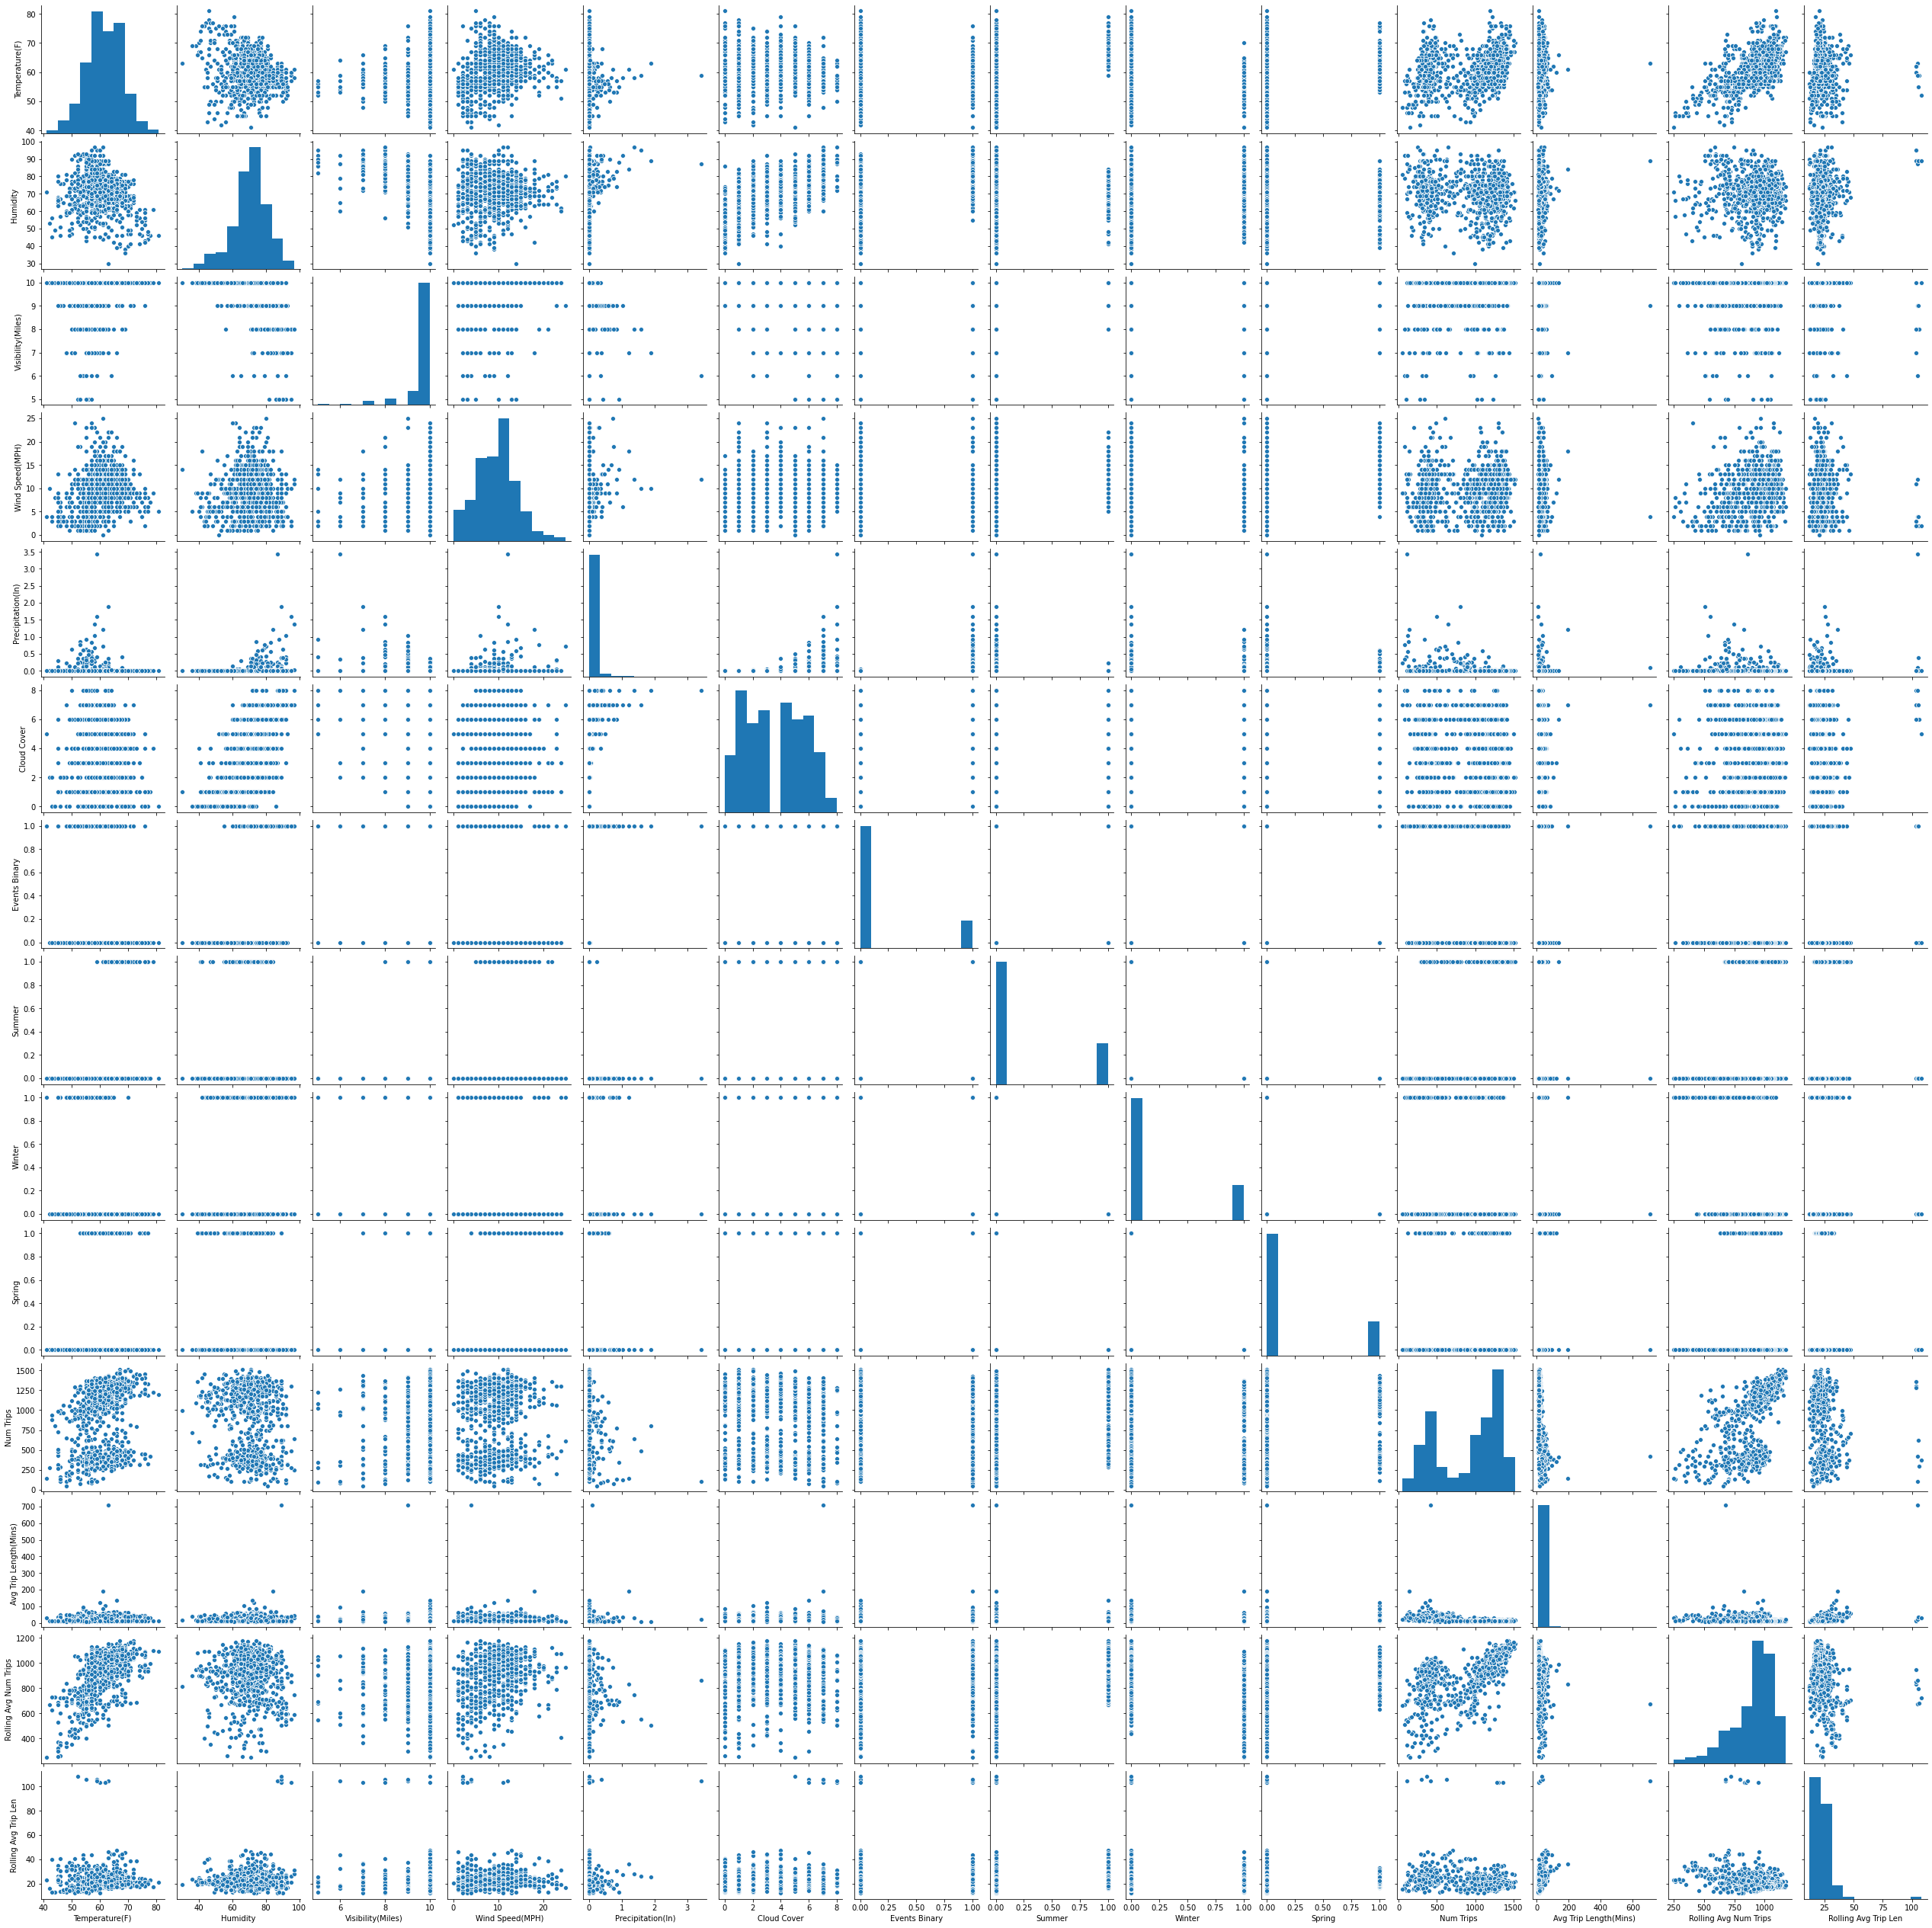

In [25]:
sns.pairplot(concat)

In [26]:
stats_bikes = min_max_avg(concat[['Num Trips','Avg Trip Length(Mins)','Rolling Avg Num Trips']])
print(stats_bikes)

[['Num Trips', 'min', 51, 'max', 1516, 'avg', 904.27], ['Avg Trip Length(Mins)', 'min', 8.53, 'max', 710.07, 'avg', 23.24], ['Rolling Avg Num Trips', 'min', 249.75, 'max', 1176.75, 'avg', 905.89]]


(array([  7.,  12.,  14.,  31.,  64.,  70., 112., 239., 214.,  92.]),
 array([ 249.75,  342.45,  435.15,  527.85,  620.55,  713.25,  805.95,
         898.65,  991.35, 1084.05, 1176.75]),
 <a list of 10 Patch objects>)

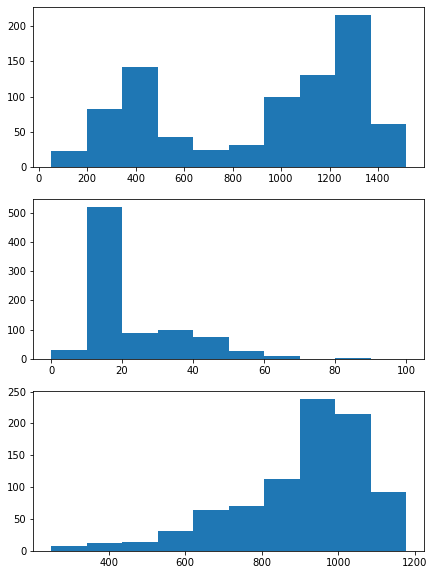

In [27]:
plt.figure(figsize = (7,10))
plt.subplot(3, 1, 1)
plt.hist(concat['Num Trips'])
plt.subplot(3, 1, 2)
plt.hist(concat['Avg Trip Length(Mins)'],bins = (0,10,20,30,40,50,60,70,80,90,100))
plt.subplot(3, 1, 3)
plt.hist(concat['Rolling Avg Num Trips'])

In [28]:
max_trip_len = concat[concat['Avg Trip Length(Mins)']>100]
max_trip_len.head()

,Date,Temperature(F),Humidity,Visibility(Miles),Wind Speed(MPH),Precipitation(In),Cloud Cover,Events Binary,Summer,Winter,Spring,Num Trips,Avg Trip Length(Mins),Rolling Avg Num Trips,Rolling Avg Trip Len
220,2014-04-06,62.0,67.0,10.0,7.0,0.00,2.0,0,0,0,1,378,103.98,666.500,31.18125
464,2014-12-06,63.0,89.0,9.0,4.0,0.09,7.0,1,0,0,0,419,710.07,675.250,104.57375
528,2015-02-08,61.0,84.0,7.0,18.0,1.21,7.0,1,0,1,0,141,192.37,828.625,36.26500
611,2015-05-02,60.0,73.0,10.0,9.0,0.00,3.0,0,0,0,1,351,120.35,943.250,33.21375
668,2015-06-28,66.0,72.0,10.0,12.0,0.00,6.0,0,1,0,0,407,135.77,987.875,35.22375


### 2.1
It appears that the day 12/06/2014 is a statistical outlier due to the extremely high number of trips that were taken that day. I will use an outlier test to confirm. To do this, I will use the outlier threshhold formula 1.5(Q3-Q1)+Q3. I used the describe() function to quickly determine the quartiles in the data, and used a quartiles table to calculate the outlier threshold.

In [29]:
quartiles = concat.quantile(q=[0.25,0.75])
quartiles_t = quartiles.transpose()
quartiles_t['outlier_thresh']=1.5*(quartiles_t[0.75]-quartiles_t[0.25])+quartiles_t[0.75]
thresholds = quartiles_t['outlier_thresh']
thresholds = thresholds.reset_index()
print(thresholds)

                    index  outlier_thresh
0          Temperature(F)         79.5000
1                Humidity         95.0000
2       Visibility(Miles)         10.0000
3         Wind Speed(MPH)         21.0000
4       Precipitation(In)          0.0000
5             Cloud Cover          9.5000
6           Events Binary          0.0000
7                  Summer          0.0000
8                  Winter          0.0000
9                  Spring          0.0000
10              Num Trips       2502.0000
11  Avg Trip Length(Mins)         56.9850
12  Rolling Avg Num Trips       1373.6875
13   Rolling Avg Trip Len         34.1475


In [30]:
concat.describe()

,Temperature(F),Humidity,Visibility(Miles),Wind Speed(MPH),Precipitation(In),Cloud Cover,Events Binary,Summer,Winter,Spring,Num Trips,Avg Trip Length(Mins),Rolling Avg Num Trips,Rolling Avg Trip Len
count,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000,855.000000
mean,61.091228,70.624561,9.661988,9.385965,0.036088,3.530994,0.184795,0.249123,0.221053,0.217544,904.273684,23.239883,905.891447,23.319893
std,6.462184,10.537903,0.861154,4.419277,0.188169,2.190283,0.388359,0.432758,0.415199,0.412817,412.750056,28.448834,173.538795,9.613290
min,41.000000,30.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000,8.530000,249.750000,12.108750
25%,57.000000,65.000000,10.000000,6.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,439.500000,12.235000,819.937500,19.066250
50%,61.000000,72.000000,10.000000,9.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1046.000000,15.250000,943.250000,21.578750
75%,66.000000,77.000000,10.000000,12.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1264.500000,30.135000,1041.437500,25.098750
max,81.000000,97.000000,10.000000,25.000000,3.430000,8.000000,1.000000,1.000000,1.000000,1.000000,1516.000000,710.070000,1176.750000,108.320000


In [31]:
plot_data = concat[concat['Avg Trip Length(Mins)']<=56.985]
plot_data = plot_data[plot_data['Temperature(F)']<=79.5]
plot_data = plot_data[plot_data['Humidity']<=95.0]
plot_data = plot_data[plot_data['Wind Speed(MPH)']<=21]
plot_data = plot_data[plot_data['Rolling Avg Trip Len']<=34.1475]
len(plot_data)

778

## Part Three: Statistical Analysis & Preliminary Modeling
To determine the affect of weather patterns on bike rentals, I created a heatmap and created a preliminary model using sklearn.

Based on the heatmap, I noticed that the trip number seems to be more affected by weather than the length of the trips. Seeing the correlations from the heatmap, I made a preliminary model with the number of trips as the dependent variable. 

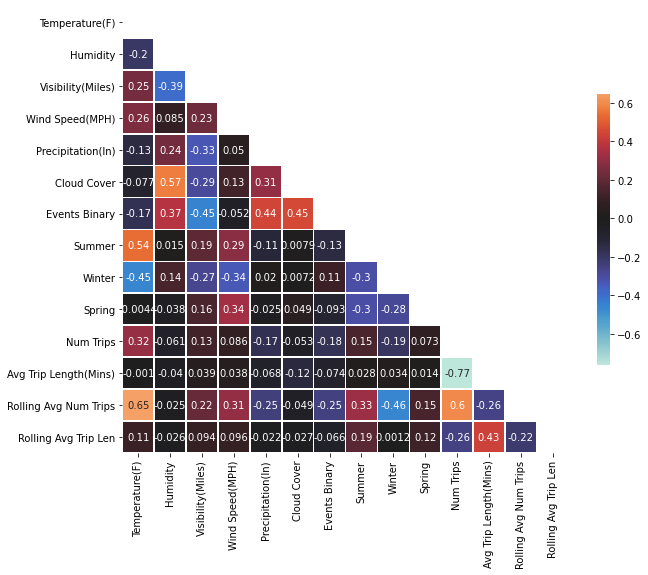

In [32]:
df_temp = plot_data.set_index('Date')
corr = df_temp.corr(method = 'pearson')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(corr, mask=mask, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [33]:
x_num_trips = plot_data[['Temperature(F)','Humidity','Visibility(Miles)','Wind Speed(MPH)','Precipitation(In)','Cloud Cover','Events Binary','Spring','Winter','Summer']]
y1 = plot_data['Num Trips']
train_X, val_X, train_y, val_y = train_test_split(x_num_trips, y1, random_state = 0)
model =  linear_model.LinearRegression().fit(x_num_trips, y1)
model.fit(train_X,train_y)
predictions = model.predict(val_X)
print(mean_absolute_error(val_y, predictions))

328.67450025670774


In [34]:
model.score(x_num_trips, y1)

0.1312095187985397

## Part Four: Model Troubleshooting

The $R^{2}$ of the above model suggests that weather has a low impact on bike rentals, which is not expected. This suggests that there are trends in the data that are not being accounted for. In an effort to improve the model, I used the date column to create scatterplots to see there is a trend in the dependent variables over time. 

From the scatterplot results,I noticed two distinct trends in the number of rentals per day. Based on this observation, I created a new binary variable that takes day of the week into account, and found that adding this variable to my above model changed my $R^{2}$ value from 0.13 to 0.80. 

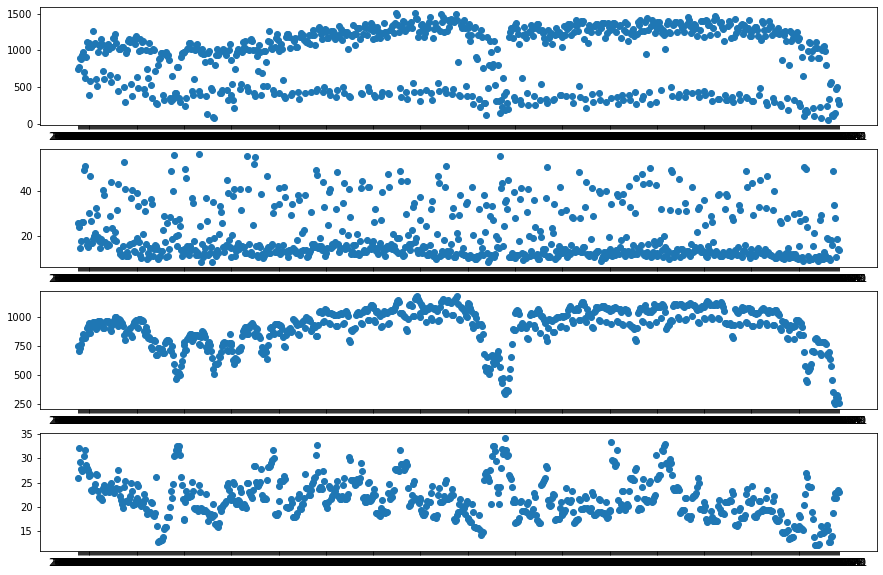

In [35]:
x = plot_data['Date']
y1 = plot_data['Num Trips']
y2 = plot_data['Avg Trip Length(Mins)']
y3 = plot_data['Rolling Avg Num Trips']
y4 = plot_data['Rolling Avg Trip Len']
fig = plt.figure(figsize=(15,10))
ax = plt.axes()
plt.subplot(4, 1, 1)
plt.scatter(x,y1)
plt.subplot(4, 1, 2)
plt.scatter(x,y2)
plt.subplot(4, 1, 3)
plt.scatter(x,y3)
plt.subplot(4, 1, 4)
plt.scatter(x,y4)
plt.show()

In [36]:
import datetime 
  
def findDay(date): 
    day = datetime.datetime.strptime(date, '%Y-%m-%d').weekday() 
    return (day)

plot_data['day'] = plot_data['Date'].apply(findDay)
plot_data['day'].value_counts()
# 0 = Monday; 6 = Sunday

3    117
2    117
0    114
4    112
1    112
5    106
6    100
Name: day, dtype: int64

In [37]:
plot_data['is_weekend'] = np.where(plot_data['day']>4,1,0 )
plot_data['is_weekend'].value_counts()

0    572
1    206
Name: is_weekend, dtype: int64

In [38]:
plot_data.drop(columns='day',inplace = True)
x_num_trips = plot_data[['Temperature(F)','Humidity','Visibility(Miles)','Wind Speed(MPH)','Precipitation(In)','Cloud Cover','Events Binary','Spring','Winter','Summer', 'is_weekend']]
y1 = plot_data['Num Trips']
train_X, val_X, train_y, val_y = train_test_split(x_num_trips, y1, random_state = 0)
model =  linear_model.LinearRegression().fit(x_num_trips, y1)
model.fit(train_X,train_y)
predictions = model.predict(val_X)
print(mean_absolute_error(val_y, predictions))

133.01329803741245


In [39]:
model.score(x_num_trips, y1)

0.8073113851762841

### 4.2 
When we add the weekend variable to the model, the $R^{2}$ value jumped from 13% to 81%! This means that almost 70% of the variations in trip data can be explained by the weekend variable. We can see that the day of the week is a major factor in the number of trips on a given day, so I will separate the dates into two dataframes to perform the regression analysis: weekday trip data, and weekend trip data. 

## Part Five: Regression Analysis in Excel 

*Note: I realized that separating the data this way rendered the rolling averages irrelevant, since they were created using data of all seven days preceding the date of each row. Because of this, I dropped these columns when creating the weekend and weekday dataframes.* 

I downloaded the dataframes as CSV files so that they could be analyzed in Excel. I then put both dataframes into one workbook and performed regression analysis on the number of trips and trip length for both the weekday and weekend data (four total). I used the p-values of each variable to determine which weather factor was a major predictor for each regression, and isolated those variables for the formulas for each regression. I also looked at the adjusted $R^{2}$ for the formulas, to see how much of the variation in the number of trips and trip length can be explained by the weather. 



In [40]:
weekend = plot_data[plot_data['is_weekend'] == 1].drop(columns = ['is_weekend','Rolling Avg Num Trips','Rolling Avg Trip Len'])
weekend.to_csv('/Users/Austen/Desktop/python/SF Bike and Weather Data Weekend.csv')

weekday = plot_data[plot_data['is_weekend'] == 0].drop(columns = ['is_weekend','Rolling Avg Num Trips','Rolling Avg Trip Len'])
weekday.to_csv('/Users/Austen/Desktop/python/SF Bike and Weather Data Weekday.csv')

### 5.1: Number of Trips Regressions
#### Weekday Number of Trips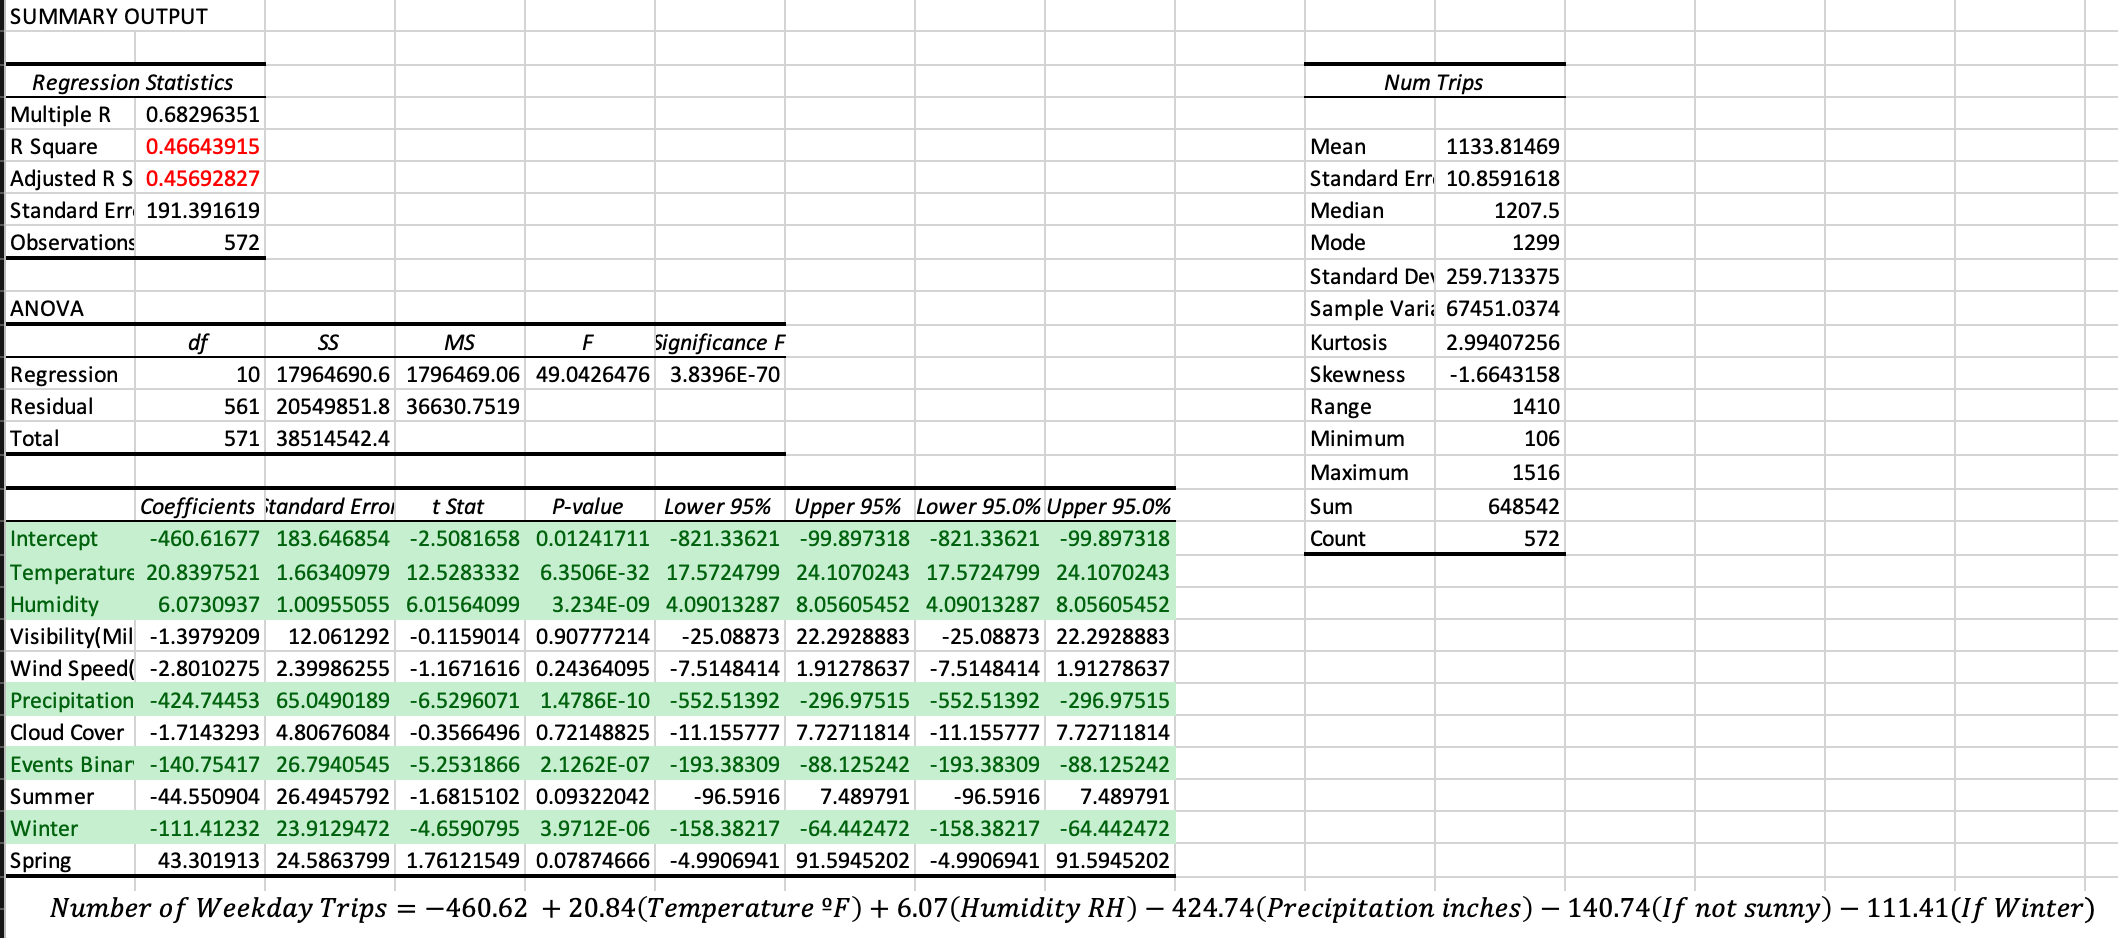

According to this model, weather events explained **45.6%** of the variation in the number of trips on weekdays.
The significant factors were: 
- Temperature 
- Humidity 
- Precipitation 
- Rain/Fog (events binary) 
- if the date was in Winter 

*Note: The intercept having a significant p-value corresponds to the binary dummy variable events binary being significant in this regression.*

The skew value indicates that the data is skewed left, with more dates having a trip number below the mean. The kurtosis value additionally indicates that the peak in the data resembles that of a normal distribution. 

(array([  6.,  12.,  11.,  12.,  18.,  29.,  97., 134., 196.,  57.]),
 array([ 106.,  247.,  388.,  529.,  670.,  811.,  952., 1093., 1234.,
        1375., 1516.]),
 <a list of 10 Patch objects>)

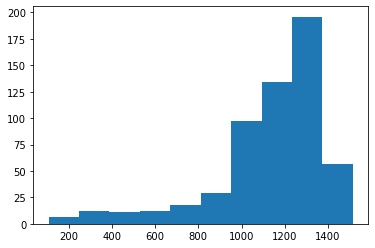

In [41]:
plt.hist(weekday['Num Trips'])



#### Weekend Number of Trips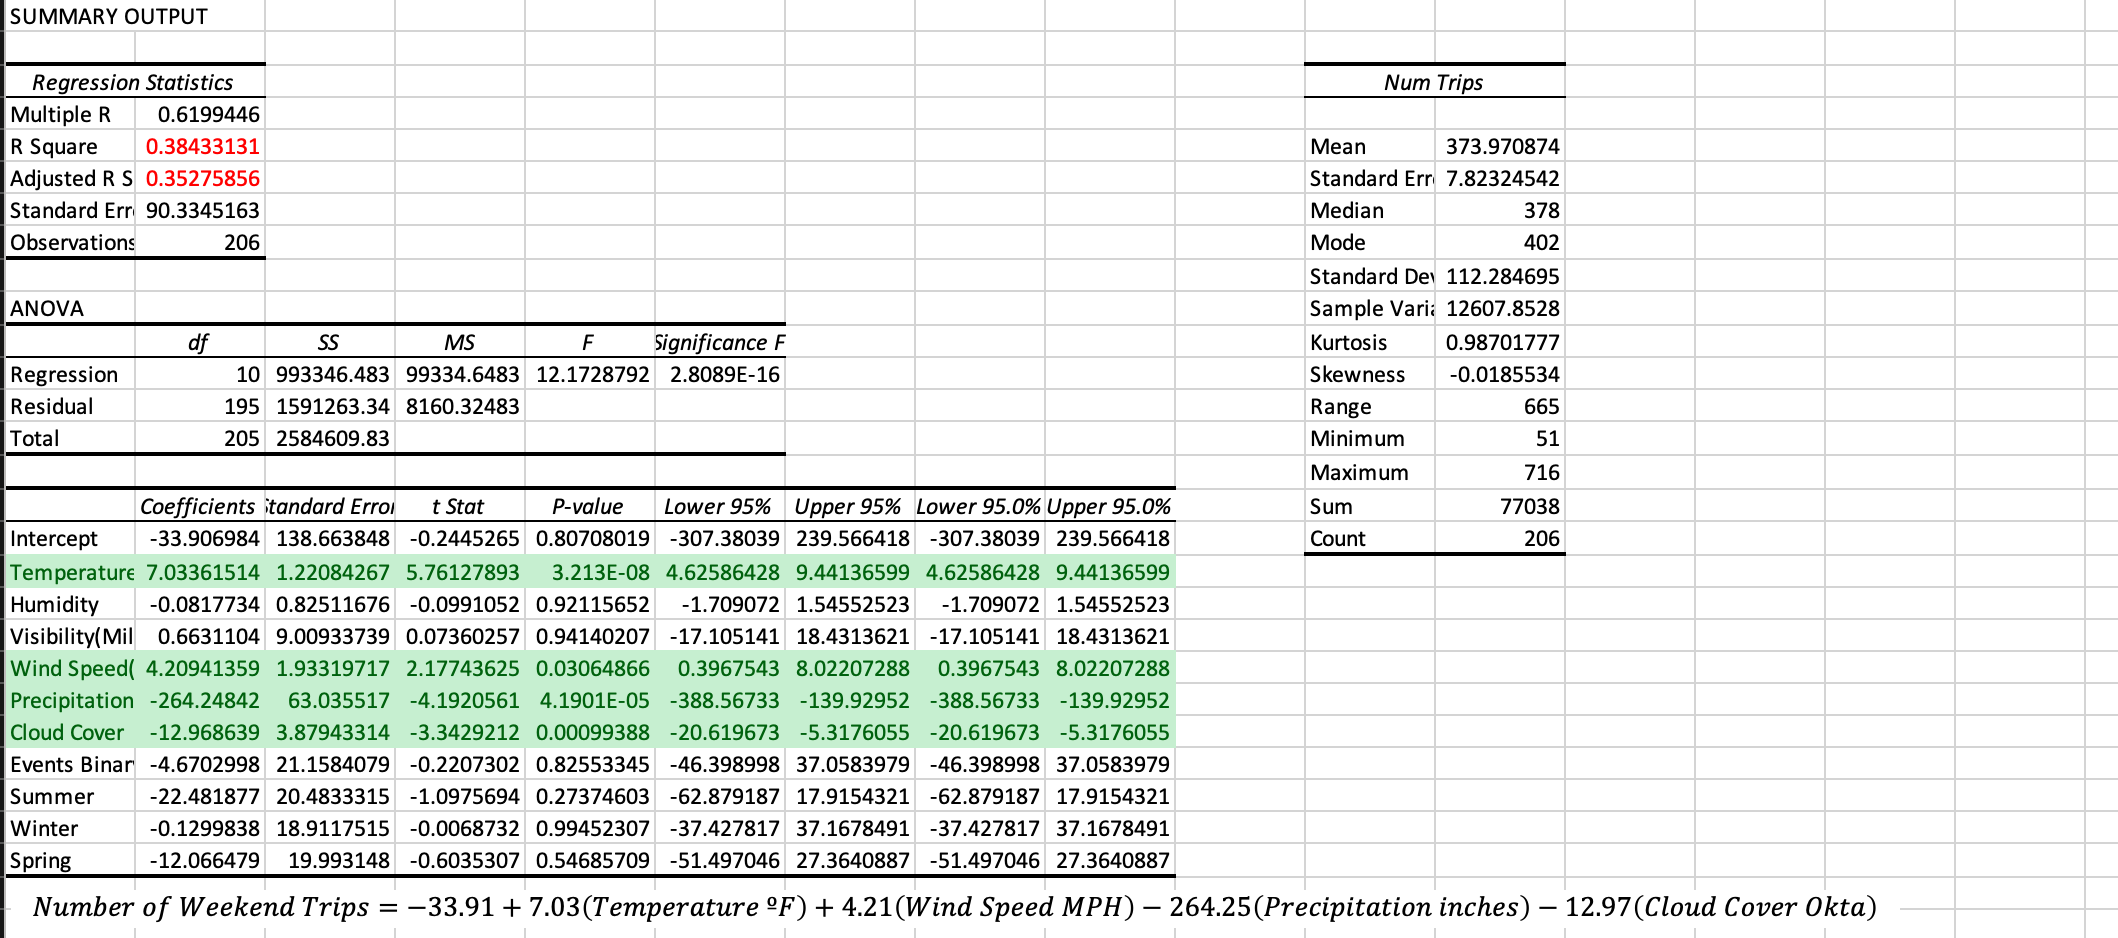

According to this model, weather events explained **35.2%** of the variation in the number of trips on weekends.<br>
The significant factors were: 
- Temperature 
- Wind speed  
- Precipitation 
- Cloud cover 

The skew indicates that the data does not have a skew, and the kurtosis value indicates that the data has a broader range than the weekday data does: 

(array([ 5.,  5., 13., 30., 54., 59., 23.,  8.,  6.,  3.]),
 array([ 51. , 117.5, 184. , 250.5, 317. , 383.5, 450. , 516.5, 583. ,
        649.5, 716. ]),
 <a list of 10 Patch objects>)

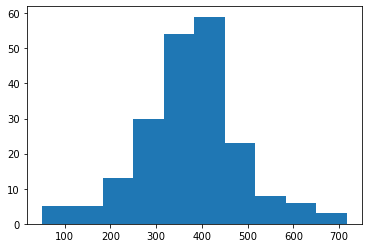

In [42]:
plt.hist(weekend['Num Trips'])


### 5.2: Trip Number Analysis of Results 

Because we are predicting human behavior, which is inherently unpredictable, an $R^{2}$ under 0.5 is to be expected. With that in mind, being able to explain 35%-45% percent of the variation in bike rentals is an exciting amount. A downturn in bike rentals in a particular month could be largely due to weather. 

There is an overlap in the events that are significant in both regressions: there is a positive correlation to higher temperatures, and a negative correlation to precipitation. Although there are other significant factors, the company can largely use these two factors as a proxy to explain variation in bike rentals. 

### 5.3: Regression of Trip Length 

#### Weekday Trip Length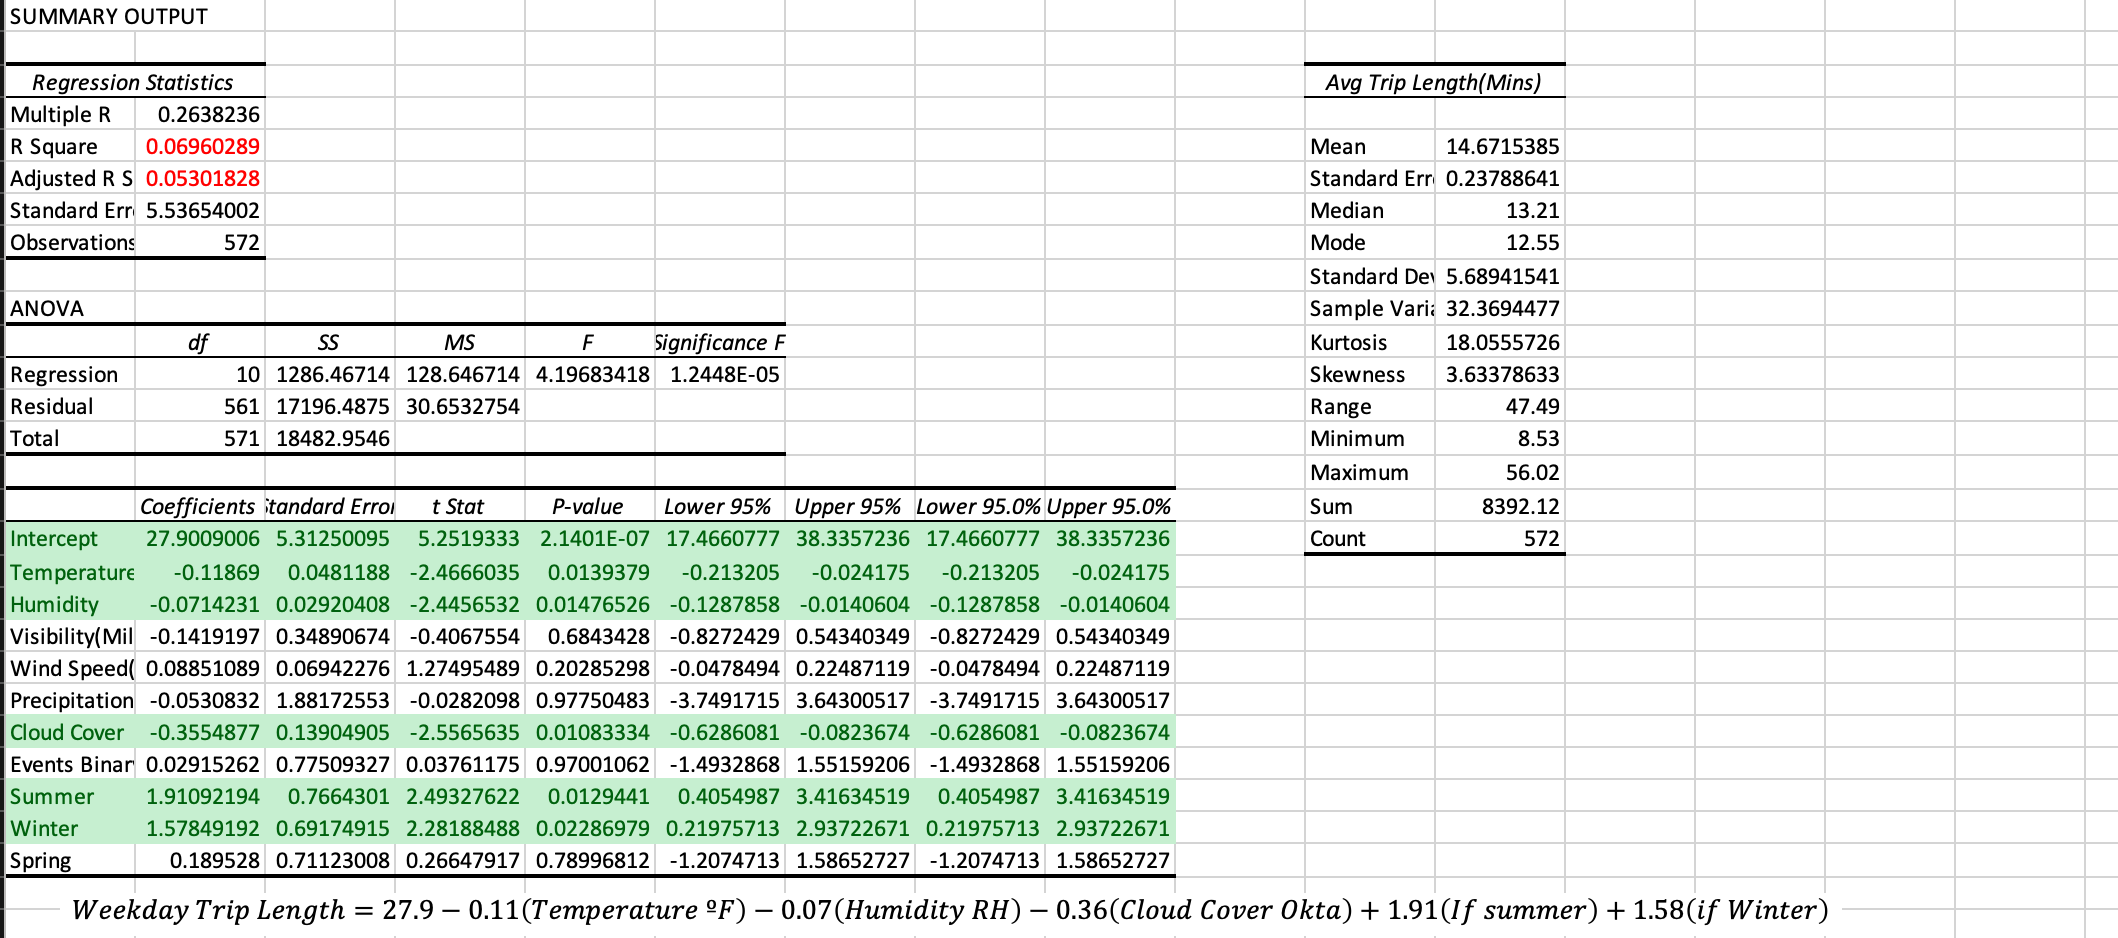

According to this model, weather events explained **5.3%** of the variation in trip length on weekdays.<br>
The significant factors were: 
- Temperature 
- Humidity   
- Cloud cover 
- Season: In particular, Summer, Winter, and - because the intercept is significant -  Autumn. 

The skew value indicates that there is a positive skew to the data, with a higher number of trips above the mean. The kurtosis value indicates a very narrow distribtuion of values centered around the mean: 

(array([  0.,  27., 367., 128.,  24.,  11.,  15.]),
 array([ 0,  5, 10, 15, 20, 25, 30, 60]),
 <a list of 7 Patch objects>)

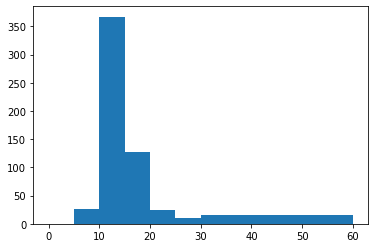

In [43]:
plt.hist(weekday['Avg Trip Length(Mins)'], bins = (0,5,10,15,20,25,30,60))

Weekend Trip Length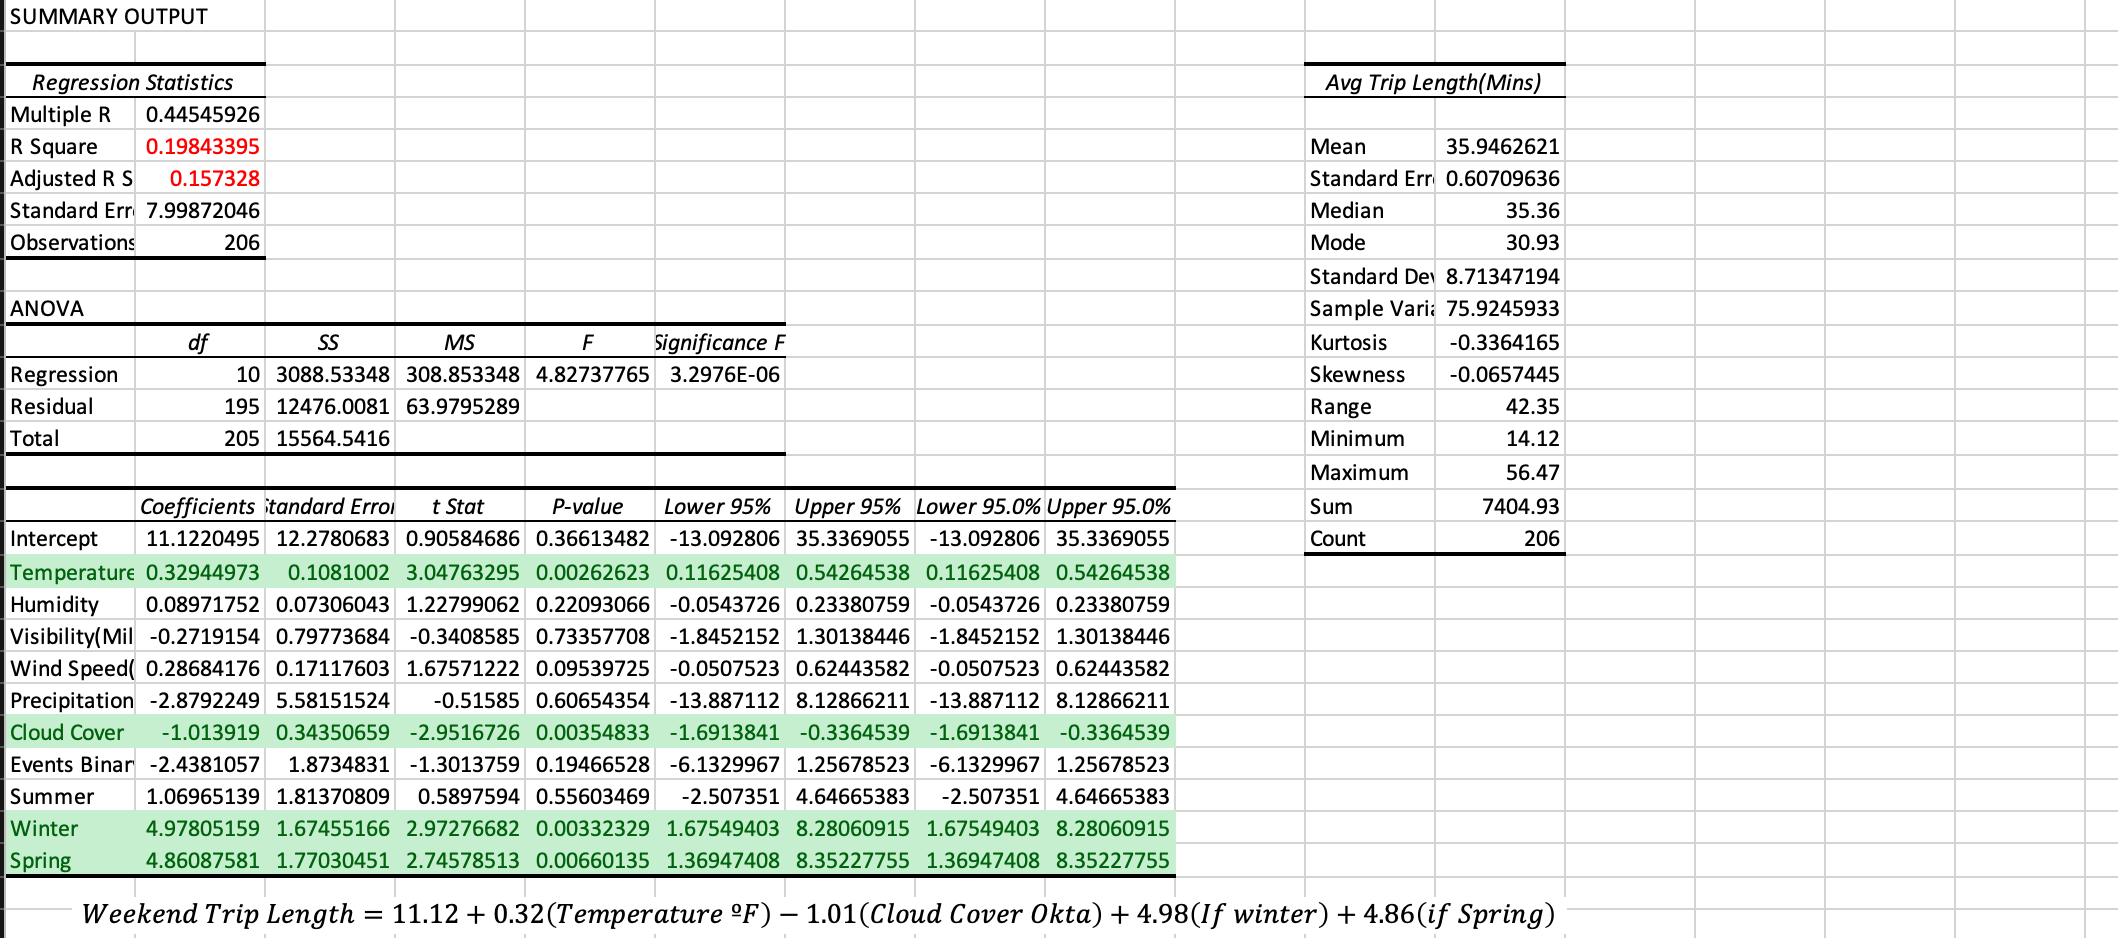

According to this model, weather events explained **15.7%** of the variation in trip length on weekdays.<br>
The significant factors were: 
- Temperature   
- Cloud cover 
- Season: In particular, Summer and Spring.<br>

The data is not skewed, and the kurtosis value indicates a broad range of values: 

(array([ 5.,  9., 13., 35., 40., 30., 33., 21., 15.,  5.]),
 array([14.12 , 18.355, 22.59 , 26.825, 31.06 , 35.295, 39.53 , 43.765,
        48.   , 52.235, 56.47 ]),
 <a list of 10 Patch objects>)

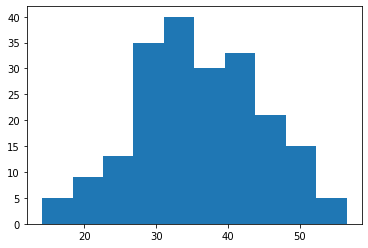

In [44]:
plt.hist(weekend['Avg Trip Length(Mins)'])


### 5.4: Trip Length Analysis of Results

The $R^{2}$ of the trip length regressions were much lower than those of the trip number regressions. For weekdays, weather doesn't seem to predict any of the variation in trip length. It is a little better for weekends, but not much. The good news is that the trip lengths seem to be fairly consistent for weekday travel, likely because bike use during the week is mostly due to commuting. The $R^{2}$ is a little better for weekends, when bikes are more likely used because people are choosing to use them, not because they have anywhere in particular to be. 

### 5.5: Conclusion

Overall, we can see that the weather is a good predictor for the number of bike rentals, but not trip length. Although the trip length is not very affected by weather, we can use the regression for the number of trips to explain some of the variation in the number of trips. Bad weather would explain a downturn in the number of bike rentals, and good weather would explain an upturn. The most important factors are temperature, which is positively correlated to an increase, and precipitation, which has a negative correlation. 

Looking at the difference in bike rentals between weekdays and weekends and the short trip length on weekdays, the company may also want to consider strategies to increase usage for reasons outside workday commutes. 